<a href="https://colab.research.google.com/github/swiryat/Alice-skill/blob/master/log_reg_pca_and_with_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate,  GridSearchCV
from category_encoders import TargetEncoder

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline

In [ ]:
pd.set_option("display.max_columns", 100)

# Функции

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Оценивает классификационную модель по множеству метрик на трейне и тесте,
    строит один общий ROC-кривой график и возвращает сводную таблицу метрик.

    Args:
        model: Обученная модель, реализующая методы `predict` и `predict_proba`.
        X_train (pd.DataFrame or np.ndarray): Признаки обучающей выборки.
        y_train (pd.Series or np.ndarray): Целевая переменная обучающей выборки.
        X_test (pd.DataFrame or np.ndarray): Признаки тестовой выборки.
        y_test (pd.Series or np.ndarray): Целевая переменная тестовой выборки.

    Returns:
        pd.DataFrame: Таблица метрик для трейна и теста с колонками:
                      ['Dataset', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'].

    """
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Предсказания вероятностей для ROC AUC
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Метрики
    metrics = {
        'Dataset': ['Train', 'Test'],
        'Accuracy': [
            accuracy_score(y_train, y_train_pred),
            accuracy_score(y_test, y_test_pred)
        ],
        'Precision': [
            precision_score(y_train, y_train_pred),
            precision_score(y_test, y_test_pred)
        ],
        'Recall': [
            recall_score(y_train, y_train_pred),
            recall_score(y_test, y_test_pred)
        ],
        'F1 Score': [
            f1_score(y_train, y_train_pred),
            f1_score(y_test, y_test_pred)
        ],
        'ROC AUC': [
            roc_auc_score(y_train, y_train_proba),
            roc_auc_score(y_test, y_test_proba)
        ]
    }

    results_df = pd.DataFrame(metrics)

    # ROC-кривая
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {metrics["ROC AUC"][0]:.3f}', linestyle='--')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {metrics["ROC AUC"][1]:.3f}', linestyle='-')
    plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Train vs Test')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df


# Загрузка данных

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data

описание данных https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [ ]:
try:
  df = pd.read_csv("hotel_bookings.csv")
except:
  df = pd.read_csv("https://drive.google.com/uc?id=1H1YQexjDN7Ud_rOmjVx0kFzuWBxuTAwl")


In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
target = "is_canceled"

# Разделение на X и y
X_full = df.drop(columns=[target])
y = df[target]

# Определим числовые и категориальные признаки
num_cols = X_full.select_dtypes(include="number").columns.tolist()
cat_cols = X_full.select_dtypes(include="object").columns.tolist()

In [ ]:
num_cols

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

признак Company	- Categorical	ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons

признак Agent	Categorical	ID of the travel agency that made the bookinga

исключим

In [ ]:
num_cols.remove('company')
cat_cols.append('company')

In [ ]:
num_cols.remove('agent')
cat_cols.append('agent')

In [ ]:

num_cols.remove('arrival_date_year')
cat_cols.append('arrival_date_year')

In [ ]:
cat_cols

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date',
 'company',
 'agent',
 'arrival_date_year']

><font color='orange'> как обрабатывать категориальные признаки мы еще не знаем, поэтому исключаем их из последюущего анализа

In [ ]:
X_full = X_full[num_cols].copy()

In [ ]:
X_full

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,342,27,1,0,0,2,0.0,0,0,0,0,3,0,0.00,0,0
1,737,27,1,0,0,2,0.0,0,0,0,0,4,0,0.00,0,0
2,7,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
3,13,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
4,14,27,1,0,2,2,0.0,0,0,0,0,0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0
119386,102,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2
119387,34,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4
119388,109,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0


# <font color='green'>EDA

In [ ]:
# === Общая информация ===
print("Размерность датасета:", X_full.shape)
print("\nТипы данных:")
print(X_full.dtypes.value_counts())

Размерность датасета: (119390, 16)

Типы данных:
int64      14
float64     2
Name: count, dtype: int64



Распределение target (is_canceled):
is_canceled
0    0.629584
1    0.370416
Name: proportion, dtype: float64


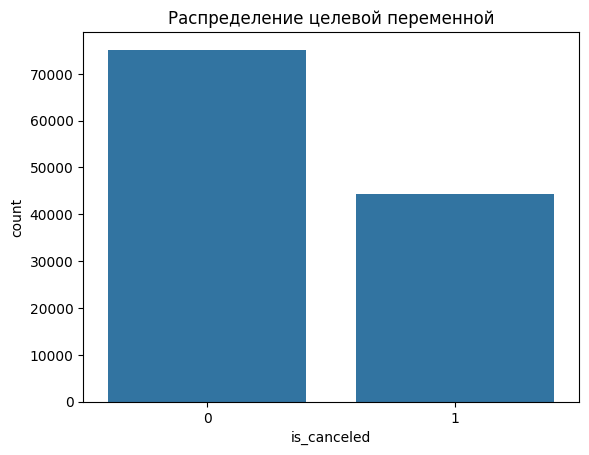

In [ ]:
# === Распределение целевой переменной ===
print("\nРаспределение target (is_canceled):")
print(df["is_canceled"].value_counts(normalize=True))
sns.countplot(x="is_canceled", data=df)
plt.title("Распределение целевой переменной")
plt.show()

In [ ]:
# === Пропуски ===
missing = X_full.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\nПризнаки с пропусками:")
print(missing)


Признаки с пропусками:
children    4
dtype: int64


In [ ]:
# описание данных
X_full[num_cols].describe().T.sort_values("std", ascending=False)

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
adr,119390.0,101.831122,50.535790,-6.38,69.29,94.575,126.0,5400.0
days_in_waiting_list,119390.0,2.321149,17.594721,0.00,0.00,0.000,0.0,391.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
total_of_special_requests,119390.0,0.571363,0.792798,0.00,0.00,0.000,1.0,5.0


<Axes: xlabel='lead_time', ylabel='Count'>

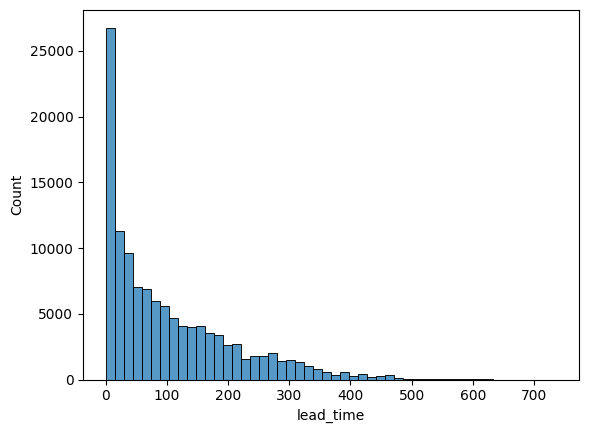

In [ ]:
sns.histplot(X_full['lead_time'], bins=50)

<Axes: xlabel='adults', ylabel='Count'>

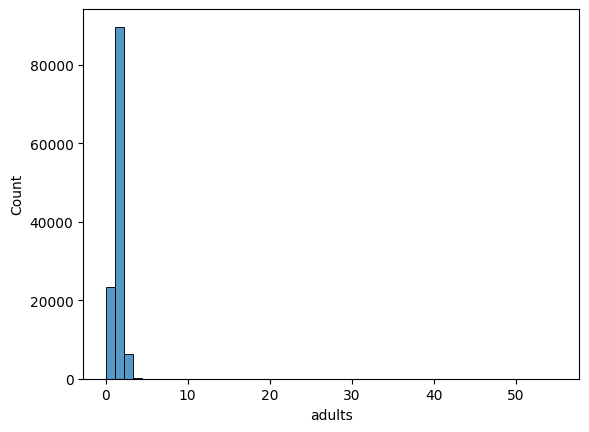

In [ ]:
sns.histplot(X_full['adults'], bins=50)

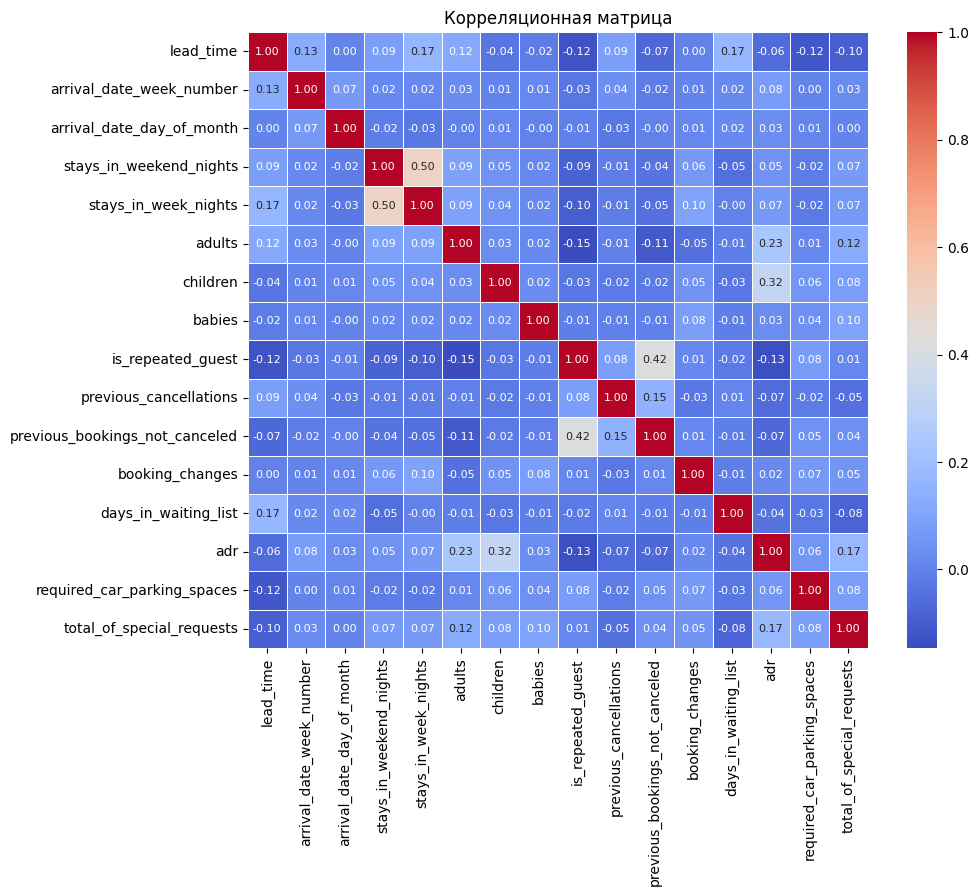

In [ ]:
# Корреляция
plt.figure(figsize=(10, 8))
corr = X_full.corr()
sns.heatmap(corr, annot=True, fmt='.2f',annot_kws={'size':8}, cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("Корреляционная матрица")
plt.show()

# <font color='green'>деление на трейн и тест

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full[num_cols], y, test_size=0.2, random_state=42)


# <font color='green'>Подготовка данных для обучения моделей

In [ ]:
# ============ Импутация ============
# Числовые — среднее
num_imputer = SimpleImputer(strategy="mean")
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])

In [ ]:
# ============ Удаление низкой дисперсии ============
var_thresh = VarianceThreshold(threshold=0.005)
var_thresh.fit_transform(X_train[num_cols])

array([[ 64.  ,  18.  ,   6.  , ..., 189.  ,   0.  ,   0.  ],
       [ 34.  ,  28.  ,  10.  , ..., 146.  ,   0.  ,   0.  ],
       [  8.  ,  39.  ,  24.  , ..., 259.  ,   0.  ,   0.  ],
       ...,
       [ 74.  ,  53.  ,  27.  , ...,  92.65,   0.  ,   0.  ],
       [130.  ,  31.  ,   1.  , ..., 120.6 ,   0.  ,   2.  ],
       [ 16.  ,  31.  ,  31.  , ..., 120.  ,   0.  ,   1.  ]])

In [ ]:
removed_features = X_train.columns[~var_thresh.get_support()]
removed_features

Index([], dtype='object')

In [ ]:
X_train_num_filtered = pd.DataFrame(var_thresh.fit_transform(X_train[num_cols]),
                                    columns=np.array(num_cols)[var_thresh.get_support()])
X_test_num_filtered = pd.DataFrame(var_thresh.transform(X_test[num_cols]),
                                   columns=X_train_num_filtered.columns)

Mutual Information (MI) — это мера зависимости между двумя переменными:

Она показывает, насколько хорошо знание одного признака уменьшает неопределённость относительно целевой переменной.

Если признак полностью независим от целевой переменной → MI = 0.

Чем выше MI → тем больше информации этот признак даёт о целевой переменной.

В отличие от корреляции, MI может выявлять как линейные, так и нелинейные зависимости.



In [ ]:
mi = mutual_info_classif(
    X_train_num_filtered,  # входные числовые признаки (уже отфильтрованные по дисперсии)
    y_train,               # целевая переменная
    discrete_features='auto',  # автоматически определяет, какие признаки дискретные
    random_state=0         # для воспроизводимости
)
# Функция mutual_info_classif (из sklearn.feature_selection) возвращает массив MI-оценок, по одной на каждый признак.

In [ ]:
mi_scores = pd.Series(mi, index=X_train_num_filtered.columns).sort_values(ascending=False)
mi_scores

,0
lead_time,0.079513
adr,0.073833
previous_cancellations,0.042242
total_of_special_requests,0.039931
required_car_parking_spaces,0.031001
booking_changes,0.018513
days_in_waiting_list,0.015551
previous_bookings_not_canceled,0.010373
adults,0.009255
stays_in_week_nights,0.008507


In [ ]:
# Оставим признаки с информативностью > 0.01
selected_features = mi_scores[mi_scores > 0.01].index.tolist()
X_train_selected = X_train_num_filtered[selected_features]
X_test_selected = X_test_num_filtered[selected_features]

In [ ]:
# Масштабирование
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_selected)
# X_test_scaled = scaler.transform(X_test_selected)


# <font color='green'>Моделирование

In [ ]:
# Обучение логистической регрессии
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_selected, y_train)


LogisticRegression(max_iter=1000)

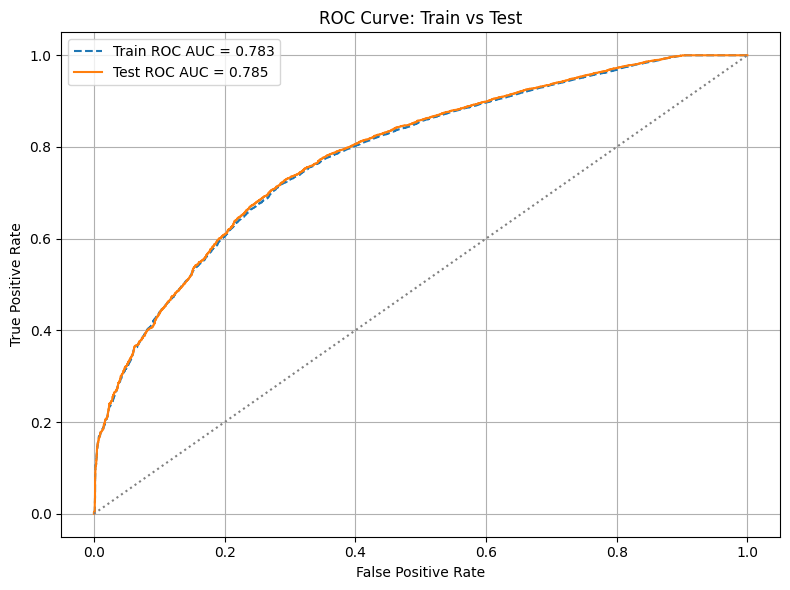

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Train,0.728945,0.689386,0.483448,0.568337,0.782722
1,Test,0.726443,0.693664,0.486902,0.572177,0.785383


In [ ]:
evaluate_model(log_reg, X_train_selected, y_train, X_test_selected, y_test)

## PCA

n_components='mle' — это способ автоматически подобрать оптимальное количество главных компонент, при котором сохраняется максимальное количество информации, но без избыточных признаков.

In [ ]:
# PCA
pca = PCA(n_components='mle' , random_state=42)  # сохраняем 99% дисперсии
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# Получим компоненты
components = pca.components_

# Создаём DataFrame для интерпретации
pc_df = pd.DataFrame(components, columns=X_train.columns, index=[f'PC{i+1}' for i in range(components.shape[0])])
pc_df

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
PC1,0.998686,0.000235,0.015986,0.000147,0.000804,0.002948,0.000628,-0.000164,-0.000018,-0.000197,0.000691,-0.000975,0.000015,0.029206,-0.038805,-0.000271,-0.000729
PC2,0.038706,0.002704,0.025069,0.005279,0.001069,0.002904,0.002714,0.002487,0.000049,-0.000496,-0.000965,-0.002279,0.000247,-0.010508,0.998845,0.000228,0.002525
PC3,-0.028915,-0.002543,0.008868,0.015986,-0.003983,-0.003271,-0.000740,-0.000374,-0.000036,-0.000058,-0.000584,0.000089,-0.000478,0.999329,0.011357,-0.000112,-0.002749
PC4,-0.016608,-0.029896,0.996362,0.073222,0.000120,-0.002284,-0.000440,-0.000616,0.000067,0.000016,0.001813,-0.000703,0.000258,-0.010291,-0.024772,0.000280,0.001298
PC5,0.001353,0.004950,-0.073365,0.997142,-0.001715,-0.006356,-0.000507,0.000314,-0.000030,-0.000039,-0.002922,0.000337,0.000816,-0.015236,-0.003635,0.000238,-0.000278
PC6,-0.003362,0.000781,0.001519,0.006694,0.307010,0.947797,0.021504,0.006019,0.001388,-0.008243,-0.017478,-0.062404,0.036329,0.004276,-0.003320,-0.001332,0.035308
PC7,0.000783,0.021502,0.001232,0.000437,0.007341,0.064377,-0.032690,0.001165,-0.000150,0.046626,0.125656,0.987394,0.010936,0.000341,0.002079,0.005953,0.034592
PC8,-0.000723,-0.174541,-0.005942,0.002928,-0.451039,0.172174,-0.035433,-0.009277,-0.004689,0.000052,0.761647,-0.088103,-0.073021,-0.002367,0.002218,-0.009915,-0.376481
PC9,-0.000306,-0.078188,-0.004036,0.001459,0.811832,-0.256700,0.048459,0.008071,0.000215,-0.005867,0.512763,-0.050497,-0.030692,0.002514,0.000463,-0.004329,-0.003215
PC10,0.000161,0.081912,0.000647,0.000774,-0.203840,0.028592,0.121907,0.009302,0.011210,0.001020,0.340186,-0.073795,0.063122,0.002314,-0.002579,0.019453,0.900166


In [ ]:
# === Количество компонент и объяснённая дисперсия ===
n_components_retained = pca.n_components_
total_explained_var = pca.explained_variance_ratio_.sum()

print(f"\nPCA: оставлено компонентов: {n_components_retained}")
print(f"Объяснённая дисперсия: {total_explained_var:.4f} ({total_explained_var*100:.2f}%)")


PCA: оставлено компонентов: 16
Объяснённая дисперсия: 1.0000 (100.00%)


In [ ]:
%%time
# Модель
log_reg_pca = LogisticRegression(max_iter=10000)
log_reg_pca.fit(X_train_pca, y_train)


CPU times: user 1min 23s, sys: 100 ms, total: 1min 23s
Wall time: 51.5 s


LogisticRegression(max_iter=10000)

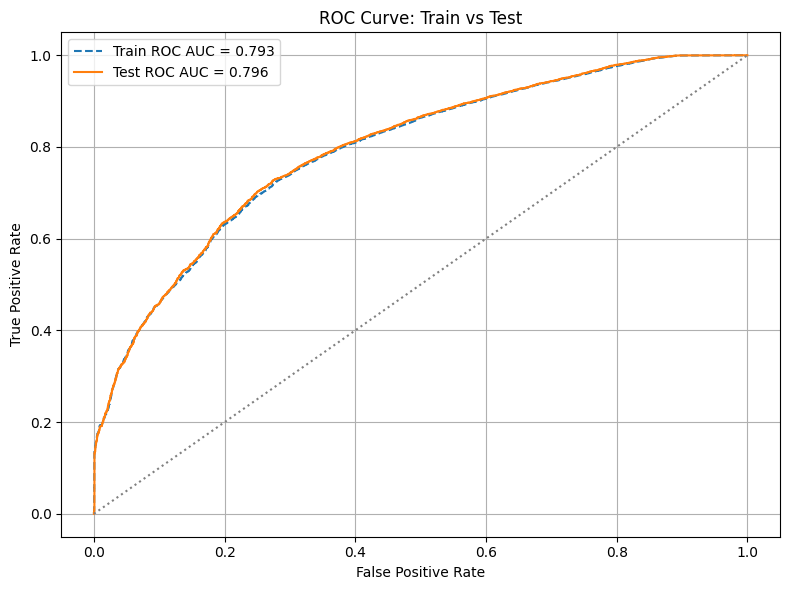

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Train,0.737321,0.706217,0.493688,0.581131,0.793453
1,Test,0.735531,0.712344,0.496600,0.585222,0.795829


In [ ]:
evaluate_model(log_reg_pca, X_train_pca, y_train, X_test_pca, y_test)

# CatBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full[num_cols+cat_cols], y, test_size=0.2, random_state=42)

In [ ]:
cat_pipe = Pipeline(
    [

        (
            'enc',
            TargetEncoder(cols = cat_cols)

         ),
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'scaler',
            StandardScaler()
        ),

    ]
)

In [ ]:
num_pipe = Pipeline(
    [
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'scaler',
            StandardScaler()
        ),

    ]
)

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols),
    ],
    remainder='passthrough'
)

In [ ]:
# сохраним обработанные датасеты (если в этом есть необходимость)
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train, y_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)

In [ ]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', RandomForestClassifier(random_state=45))
    ]
)

In [ ]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('enc',
                                                                   TargetEncoder(cols=['hotel',
                                                                                       'arrival_date_month',
                                                                                       'meal',
                                                                                       'country',
                                                                                       'market_segment',
                                                                                       'distribution_channel',
                                                                                       'reserved_room_type',
                                                                                       'assigned_room_type',
                                                                                       'deposit_type',
                                                                                       'customer_type',
                                                                                       'reservation_status',
                                                                                       'reservation_status_date',
                                                                                       'compa...
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests'])])),
                ('models', RandomForestClassifier(random_state=45))])

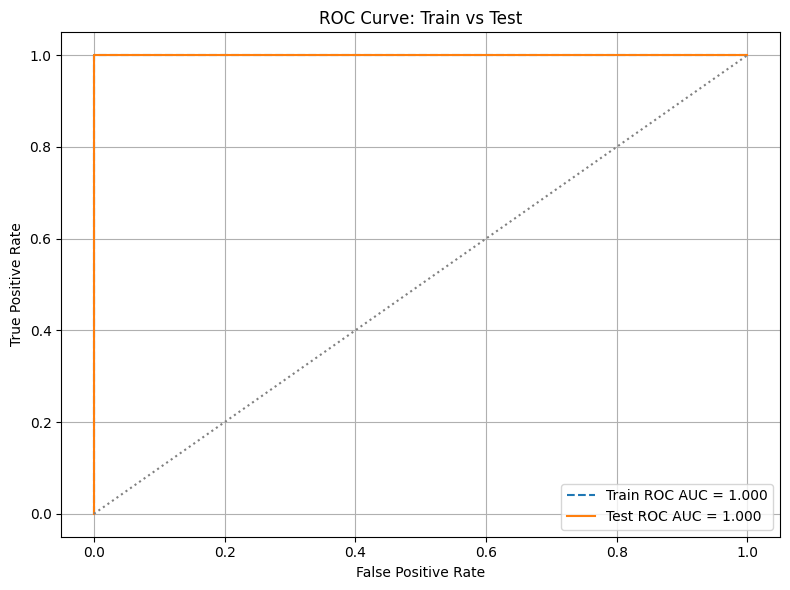

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Train,1.0,1.0,1.0,1.0,1.0
1,Test,1.0,1.0,1.0,1.0,1.0


In [ ]:
evaluate_model(pipe_final, X_train, y_train, X_test, y_test)

In [ ]:
pipe_final.steps[1][1]

RandomForestClassifier(random_state=45)

In [ ]:
importances = pipe_final.steps[1][1].feature_importances_
importances

array([1.54436557e-03, 1.96509910e-03, 7.41139944e-04, 3.01451214e-02,
       7.42483201e-03, 3.18141324e-03, 8.82850689e-04, 2.94147445e-03,
       5.61949361e-02, 6.31771944e-03, 7.32592922e-01, 6.02889181e-02,
       7.82513286e-04, 2.46342706e-02, 1.65804144e-03, 2.48581505e-02,
       2.64452659e-03, 1.70772754e-03, 1.77694853e-03, 2.60939487e-03,
       7.38413288e-04, 2.73311107e-04, 3.03849849e-05, 3.16144246e-04,
       6.56857689e-03, 9.91024159e-04, 3.66429627e-03, 1.12979797e-04,
       3.73859332e-03, 6.53916555e-03, 1.21347452e-02])

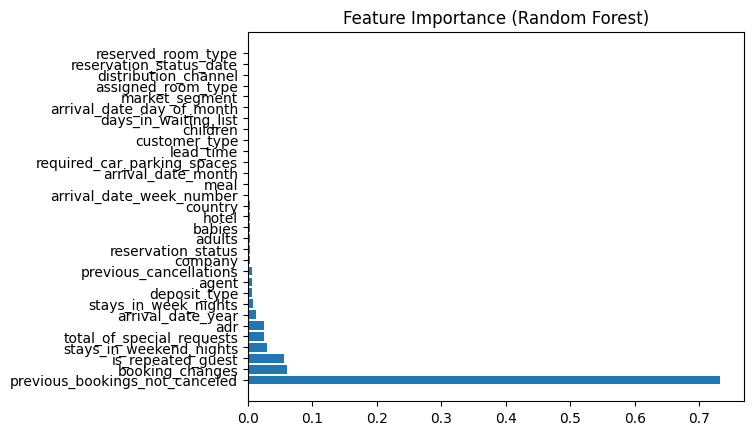

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.barh(features['Feature'], features['Importance'])
plt.title('Feature Importance (Random Forest)')
plt.show()

In [ ]:
df[['previous_bookings_not_canceled', target]].drop_duplicates()


,previous_bookings_not_canceled,is_canceled
0,0,0
8,0,1
13803,1,0
13804,2,0
13805,3,1
...,...,...
78577,16,1
80055,25,1
80265,6,1
85211,29,1
